Data set shared links : 

All types:
https://kaggle.com/datasets/01b2c4a3c820104f78f4f39069ef904fab8b779340d4954d15ae8bbf8530142d

Fundus Only:
https://kaggle.com/datasets/69df32ae0ed5e549215d16bc1dbf5b1cc0dfbd7a4a18dae3f63c96ef88467408

UWPC Only and FAF only:
https://kaggle.com/datasets/09e2221d04a9201c230566b28b2181130b9edbaac51092271c9f19d5766b7c4f

# Clear All directories Files Created 
To remove multiple comment ** Ctrl-/ 

In [1]:
# import os
# os.remove("/kaggle/working/test_data.npy")     
# os.remove("/kaggle/working/train_data.npy")  
# os.remove("/kaggle/working/LeNet_BestWeights.h5")


# import shutil                                
# shutil.rmtree("/kaggle/working/Splitted")

In [2]:
import numpy as np
import pandas as pd 
from random import shuffle
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import os
from tqdm import tqdm

!pip install split-folders
import splitfolders

!pip install tflearn
import tflearn
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.core.framework.types_pb2 import DataType
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D

In [3]:
Input = "/kaggle/input/edrop-alltypes/Combined( All types -converted- 932)" # Input is read only 

# os.mkdir('/kaggle/working/Splitted/') # working for creating R/W directory
Splitted = "/kaggle/working/Splitted"

In [4]:
splitfolders.ratio(Input, output= Splitted, seed=200, ratio=(.8, .2), 
                   group_prefix=None) # default values

Copying files: 872 files [00:14, 61.03 files/s]


In [5]:
Train = ["/kaggle/working/Splitted/train/Normal 505", "/kaggle/working/Splitted/train/RP 421"]
Test = ["/kaggle/working/Splitted/val/Normal 505", "/kaggle/working/Splitted/val/RP 421" ]

Folder = "/kaggle/working/"
ImgSize = [224, 224] # Model
Classes = ["NORMAL", "RP"]

Converting to jpg: Done explicitly in case All types dataset

In [6]:
def ConvertJPG(T, img):
    Path = os.path.join(T, img)
    i = img.split('.')
    Format = i[-1]
    ImageName = i[0]
    if Format != "jpg":
        converted = Image.open(Path).convert('RGB')
        newPath = os.path.join(T, ImageName + ".jpg") 
        converted.save(newPath)
        os.remove(Path)  # To remove png file
        return newPath
    else:
        return Path

In [7]:
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator


def ImpulseNoise(image):
    Impule_Noise = np.zeros((300, 374, 3), dtype=np.uint8)
    cv2.randu(Impule_Noise, 0, 255)
    Impule_Noise = cv2.threshold(Impule_Noise, 245, 255, cv2.THRESH_BINARY)[1]
    in_img = cv2.add(image, Impule_Noise,  dtype=cv2.CV_32F)
    return in_img

trainAug = ImageDataGenerator(
rescale = 1./ 255,
vertical_flip = True,
horizontal_flip= True,
rotation_range = 90,
brightness_range= [0.5, 1],
zoom_range = [0.8, 1.2],
shear_range = 5,
preprocessing_function = ImpulseNoise,
fill_mode='nearest')


original = ImageDataGenerator(width_shift_range=0)
    
for j in Train:
    for img in tqdm(os.listdir(j)):
        i = img.split('Augmented')       
        if(len(i) == 1):
            path = os.path.join(j, img)
            imgName = img.split('.')[0]
            aug = load_img(path, target_size=(300, 374))
            aug_array = img_to_array(aug)
            aug_array = aug_array.reshape((1,) + aug_array.shape)
            
            count = 1
            for batch in original.flow(aug_array, batch_size = 1, save_to_dir= j,save_prefix = imgName + " Original Augmented" , save_format = 'jpg'):
                count -=1
                if count == 0:
                    break

            count = 3
            for batch in trainAug.flow(aug_array, batch_size = 100, save_to_dir= j , save_prefix= imgName + "Augmented" , save_format = 'jpg'):
                count -=1
                if count == 0:
                    break

100%|██████████| 324/324 [01:12<00:00,  4.45it/s]


In [8]:
def ImagePreparation(path):
    image = np.asarray(cv2.imread(path,cv2.IMREAD_COLOR))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (ImgSize[0], ImgSize[1]), interpolation=cv2.INTER_NEAREST)
    image = image[0:224, 29:200]
    image = cv2.resize(image, (ImgSize[0], ImgSize[1]), interpolation=cv2.INTER_NEAREST)
    image = cv2.fastNlMeansDenoising(image, None, 20, 7, 21) 
    image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    img_array = np.array(image)
    return img_array

In [9]:
def Label(img):
    img = img.upper()
    l = img.split('_')
    l = l[1].split(' ')
    index = Classes.index(l[0])
    Label = np.zeros(2)
    Label[index] = 1
    return Label


In [10]:
def Create_TestData():
    testing  = []
    for j in Test:
        for img in tqdm(os.listdir(j)):
            try:
                path = ConvertJPG(j, img)
                img_array=  ImagePreparation(path)
                testing.append([img_array, Label(img)])
            except Exception as e:
                print(e)
                pass
    np.save(os.path.join(Folder, 'test_data.npy'), testing) 
    return testing

In [11]:
def Create_TrainingData():
    training  = []
    for j in Train:
        for img in tqdm(os.listdir(j)):
            try:
                path = ConvertJPG(j, img)
                img_array = ImagePreparation(path)
                training.append([img_array, Label(img)])
            except Exception as e:
                print(e)
                pass

    shuffle(training)
    np.save(os.path.join(Folder, 'train_data.npy'), training) # To be saved in the folder created for project
    return training

In [12]:
# import os
# os.remove("/kaggle/working/test_data.npy")     
# os.remove("/kaggle/working/train_data.npy")  

if (os.path.exists('train_data.npy')): 
    train_data = np.load('train_data.npy', allow_pickle=True) 
else: 
    train_data = Create_TrainingData()

if (os.path.exists('test_data.npy')):
    test_data =np.load('test_data.npy',allow_pickle=True)
else:
    test_data = Create_TestData()

print(len(train_data))
print(len(test_data))

100%|██████████| 1620/1620 [04:43<00:00,  5.72it/s]
/opt/conda/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
100%|██████████| 81/81 [00:23<00:00,  3.49it/s]

3484
175


In [13]:
def split_test_train(train, test):
    
    X_train = np.array([i[0] for i in train]).reshape(-1, ImgSize[0], ImgSize[1], 3)
    Y_train =np.array([i[1] for i in train])

    X_test = np.array([i[0] for i in test]).reshape(-1, ImgSize[0], ImgSize[1], 3)
    Y_test = np.array([i[1] for i in test])
    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = split_test_train(train_data, test_data)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3484, 224, 224, 3)
(3484, 2)
(175, 224, 224, 3)
(175, 2)


In [14]:
print(X_train.dtype)

float32


# **Models Training**

In [15]:
def LeNet():
    model=Sequential()

    model.add(Conv2D(filters=6,kernel_size=(5,5),activation="tanh",input_shape=(ImgSize[0],ImgSize[1],3)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=16,kernel_size=(5,5),activation="tanh"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=120,kernel_size=(5,5),activation="tanh"))
    model.add(MaxPooling2D(pool_size=(5,5)))

    model.add(Flatten())
    model.add(Dense(84,activation="tanh"))
    model.add(Dropout(rate=0.3))

    model.add(Dense(2,activation="sigmoid"))
    return model

LeNet = LeNet()
LeNet.summary()
LeNet.compile(optimizer= 'adamax',loss = 'binary_crossentropy',
              metrics = ['Recall','Precision','AUC', 'accuracy', tf.keras.metrics.FalseNegatives()])

LN = tf.keras.callbacks.ModelCheckpoint('LeNet_Weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')
LeNet.fit(X_train, Y_train, validation_data = (X_test , Y_test) ,callbacks=[LN] ,
          epochs=100)


# LeNet.save('LeNet_model.tf1')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 49, 120)       48120     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 120)        0

/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


3484/3484 [==============================] - 8s 2ms/sample - loss: 0.6110 - recall: 0.6676 - precision: 0.6615 - auc: 0.7284 - acc: 0.6630 - false_negatives: 1158.0000 - val_loss: 0.5114 - val_recall: 0.7714 - val_precision: 0.7714 - val_auc: 0.8374 - val_acc: 0.7714 - val_false_negatives: 40.0000
Epoch 2/100
3484/3484 [==============================] - 3s 781us/sample - loss: 0.5178 - recall: 0.7477 - precision: 0.7473 - auc: 0.8257 - acc: 0.7474 - false_negatives: 879.0000 - val_loss: 0.3824 - val_recall: 0.8629 - val_precision: 0.8483 - val_auc: 0.9254 - val_acc: 0.8543 - val_false_negatives: 24.0000
Epoch 3/100
3484/3484 [==============================] - 3s 770us/sample - loss: 0.4583 - recall: 0.7873 - precision: 0.7875 - auc: 0.8684 - acc: 0.7875 - false_negatives: 741.0000 - val_loss: 0.3286 - val_recall: 0.8743 - val_precision: 0.9107 - val_auc: 0.9428 - val_acc: 0.8943 - val_false_negatives: 22.0000
Epoch 4/100
3484/3484 [==============================] - 3s 767us/sample - lo

In [16]:
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau 
from keras.applications.inception_v3 import InceptionV3

lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
base_model = InceptionV3(weights='imagenet', include_top=False )
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)
InceptionV3 = Model(inputs=base_model.input, outputs=predictions)
InceptionV3.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), 
                  optimizer='adamax', 
                  metrics = ['Recall','Precision','AUC', 'accuracy', tf.keras.metrics.FalseNegatives()])

IV3 = tf.keras.callbacks.ModelCheckpoint('IV3_BestWeights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')
InceptionV3.fit(X_train, Y_train, validation_data = (X_test , Y_test) ,callbacks=[lr_reduce] ,
          epochs=100)



Train on 3484 samples, validate on 175 samples
Epoch 1/100


2023-06-23 19:11:07.889287: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_1/cond/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3484/3484 [==============================] - ETA: 0s - loss: 0.4746 - recall_2: 0.8361 - precision_2: 0.8337 - auc_2: 0.9046 - acc: 0.8347 - false_negatives_1: 571.0000

2023-06-23 19:11:32.898297: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_1/cond/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3484/3484 [==============================] - 28s 8ms/sample - loss: 0.4746 - recall_2: 0.8361 - precision_2: 0.8337 - auc_2: 0.9046 - acc: 0.8347 - false_negatives_1: 571.0000 - val_loss: 0.4865 - val_recall_2: 0.7829 - val_precision_2: 0.7829 - val_auc_2: 0.9017 - val_acc: 0.7829 - val_false_negatives_1: 38.0000 - lr: 0.0010
Epoch 2/100
3484/3484 [==============================] - 21s 6ms/sample - loss: 0.3268 - recall_2: 0.9254 - precision_2: 0.9225 - auc_2: 0.9771 - acc: 0.9238 - false_negatives_1: 260.0000 - val_loss: 0.3261 - val_recall_2: 0.9486 - val_precision_2: 0.9432 - val_auc_2: 0.9748 - val_acc: 0.9457 - val_false_negatives_1: 9.0000 - lr: 0.0010
Epoch 3/100
3484/3484 [==============================] - ETA: 0s - loss: 0.2708 - recall_2: 0.9641 - precision_2: 0.9636 - auc_2: 0.9920 - acc: 0.9638 - false_negatives_1: 125.0000
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
3484/3484 [==============================] - 21s 6ms/sample - loss: 0.2708 

In [17]:
import keras

def resnetmodel ():    
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(ImgSize[0], ImgSize[1], 3)))
    model.add(keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet'))
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(units=2, activation='sigmoid'))
    model.summary()
    return model 

ResNet = resnetmodel()
ResNet.compile(optimizer='adamax',loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
               metrics = ['Recall','Precision','AUC', 'accuracy', tf.keras.metrics.FalseNegatives()])

Res = tf.keras.callbacks.ModelCheckpoint('ResNet_Weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')

ResNet.fit(X_train, Y_train, epochs=100, validation_data =(X_test, Y_test), callbacks=[Res])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 23,523,458
Non-trainable params: 45,440
_________________________________________________________________
Train on 3484 samples, validate on 175 samples
Epoch 1/100
3484/3484 [==============================] - 29s 8ms/sample - loss: 0.4329 - recall_4: 0.8605 - precision_4: 0.8598 - auc_4: 0.9276 - acc: 0.8601 - false_negatives_2: 486.0000 

In [18]:
from keras.applications.vgg16 import VGG16

def VGG16():
    m = keras.Sequential()
    m.add(keras.layers.InputLayer(input_shape=(ImgSize[0], ImgSize[1], 3)))
    m.add(keras.applications.VGG16(include_top=False, weights='imagenet'))
    m.add(keras.layers.GlobalAveragePooling2D())
    m.add(keras.layers.Dense(units=2, activation='sigmoid'))
    m.summary()
    return m
    
Vgg = VGG16()
Vgg.compile(optimizer='adamax',loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
               metrics = ['Recall','Precision','AUC', 'accuracy', tf.keras.metrics.FalseNegatives()])

VGG = tf.keras.callbacks.ModelCheckpoint('VGG_BestWeights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')

Vgg.fit(X_train, Y_train, epochs=50, validation_data =(X_test, Y_test), callbacks=[VGG])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14,715,714
Trainable params: 14,715,714
Non-trainable params: 0
_________________________________________________________________
Train on 3484 samples, validate on 175 samples
Epoch 1/50
3484/3484 [==============================] - 35s 10ms/sample - loss: 0.8643 - recall_6: 0.5040 - precision_6: 0.5284 - auc_6: 0.5164 - acc: 0.5271 - false_negatives_3: 1728.0000 - va

In [19]:
from keras.applications.xception import Xception

lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
base_model = Xception(weights='imagenet', include_top=False )
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)
Xception = Model(inputs=base_model.input, outputs=predictions)
Xception.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), 
                  optimizer='adamax', 
                  metrics = ['Recall','Precision','AUC', 'accuracy', tf.keras.metrics.FalseNegatives()])

Xception.fit(X_train, Y_train, validation_data = (X_test , Y_test) ,callbacks=[lr_reduce] ,
          epochs=50)

Train on 3484 samples, validate on 175 samples
Epoch 1/50


2023-06-23 20:41:21.243662: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_2/cond/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3484/3484 [==============================] - ETA: 0s - loss: 0.5771 - recall_8: 0.7144 - precision_8: 0.6927 - auc_8: 0.7941 - acc: 0.6988 - false_negatives_4: 995.0000

2023-06-23 20:42:08.588763: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_2/cond/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3484/3484 [==============================] - 50s 14ms/sample - loss: 0.5771 - recall_8: 0.7144 - precision_8: 0.6927 - auc_8: 0.7941 - acc: 0.6988 - false_negatives_4: 995.0000 - val_loss: 0.6524 - val_recall_8: 0.7543 - val_precision_8: 0.7904 - val_auc_8: 0.8527 - val_acc: 0.7771 - val_false_negatives_4: 43.0000 - lr: 0.0010
Epoch 2/50
3484/3484 [==============================] - 44s 13ms/sample - loss: 0.3362 - recall_8: 0.9182 - precision_8: 0.9193 - auc_8: 0.9737 - acc: 0.9188 - false_negatives_4: 285.0000 - val_loss: 0.5867 - val_recall_8: 0.8800 - val_precision_8: 0.8953 - val_auc_8: 0.9377 - val_acc: 0.8886 - val_false_negatives_4: 21.0000 - lr: 0.0010
Epoch 3/50
3484/3484 [==============================] - 44s 13ms/sample - loss: 0.2638 - recall_8: 0.9667 - precision_8: 0.9662 - auc_8: 0.9937 - acc: 0.9664 - false_negatives_4: 116.0000 - val_loss: 0.4891 - val_recall_8: 0.9429 - val_precision_8: 0.9429 - val_auc_8: 0.9646 - val_acc: 0.9429 - val_false_negatives_4: 10.0000 - lr

In [20]:
##                                           Saving
# def SaveModel(model, name):
#     model.save(name)
#     model.save_weights(name)
#     # LeNet.save('LeNet_model.tf1')

# SaveModel(LeNet, "LeNet_95.4_20.6.h5")


##                                         Retraining 
# def Model_Retrain(model, name, e):
#     model.load_weights(name)
#     model.compile(optimizer= 'adamax',loss = 'binary_crossentropy',
#               metrics = ['Recall','Precision','AUC', 'accuracy', tf.keras.metrics.FalseNegatives()])
#     model.fit(X_train,Y_train,validation_data=(X_test,Y_test), epochs=e)

# Model_Retrain(LeNet, "LeNet_20.6.h5", 35)

# Model Evluating

In [64]:
def Predicted(model):
    from sklearn.metrics import confusion_matrix
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis = 1) 
    return  pred

def CM(pred):
    y_true = np.argmax(Y_test, axis = 1)
    from sklearn.metrics import confusion_matrix  
    CM = confusion_matrix(y_true, pred)
    from mlxtend.plotting import plot_confusion_matrix
    fig, ax = plot_confusion_matrix(conf_mat = CM, figsize = (5, 5))
    plt.show()
    return CM
      

def Evaluate(model):
    evaluate = model.evaluate(X_test, Y_test, verbose = 0)
    print('Test loss:- ', round(evaluate[0], 3))
    print('Test recall:- ', round(evaluate[1] * 100), 3)
    print('Test precision:- ', round(evaluate[2] * 100, 3))
    print('Test AUC:- ', round(evaluate[3] * 100,3)) 
    print('Test accuracy:- ', round(evaluate[4] * 100, 3) )
    print("FalseNegatives:- " , evaluate[5])
    
    pred = Predicted(model)
    CM(pred)

Test loss:-  0.119
Test recall:-  97 3
Test precision:-  96.571
Test AUC:-  98.916
Test accuracy:-  96.571
FalseNegatives:-  6.0


/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


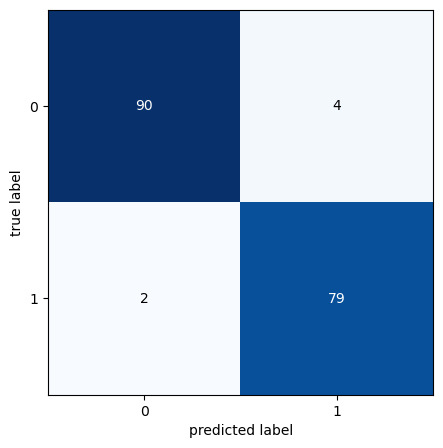

In [22]:
Evaluate(LeNet)

Test loss:-  0.313
Test recall:-  95 3
Test precision:-  94.318
Test AUC:-  97.851
Test accuracy:-  94.571
FalseNegatives:-  9.0


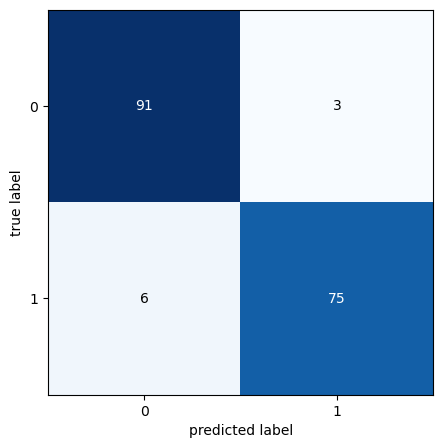

NameError: name 'SaveModel' is not defined

In [26]:
Evaluate(InceptionV3)
# SaveModel(InceptionV3, "InceptionV3.h5")

Test loss:-  0.298
Test recall:-  96 3
Test precision:-  96.0
Test AUC:-  98.038
Test accuracy:-  96.0
FalseNegatives:-  7.0


/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


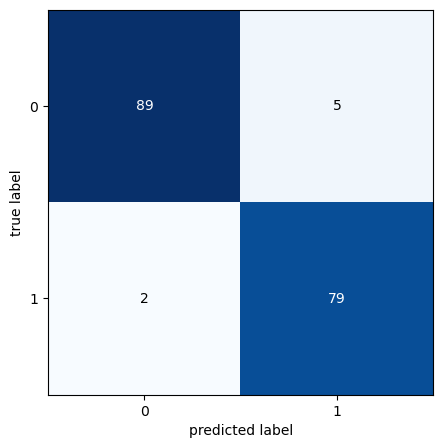

In [24]:
Evaluate(ResNet)
#SaveModel(ResNet, "ResNet_20.6.h5")

Test loss:-  0.392
Test recall:-  90 3
Test precision:-  90.286
Test AUC:-  95.966
Test accuracy:-  90.286
FalseNegatives:-  17.0


/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


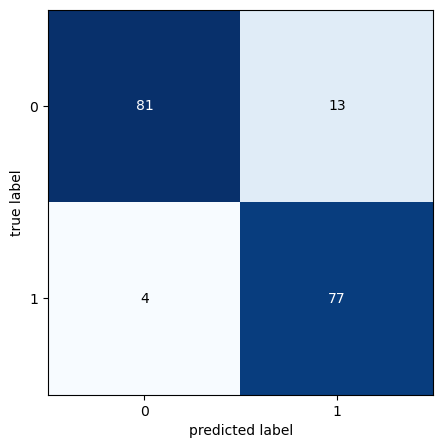

In [29]:
Evaluate(Vgg)

Test loss:-  0.304
Test recall:-  95 3
Test precision:-  95.429
Test AUC:-  96.952
Test accuracy:-  95.429
FalseNegatives:-  8.0


/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-06-23 21:23:05.259745: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_2/cond/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


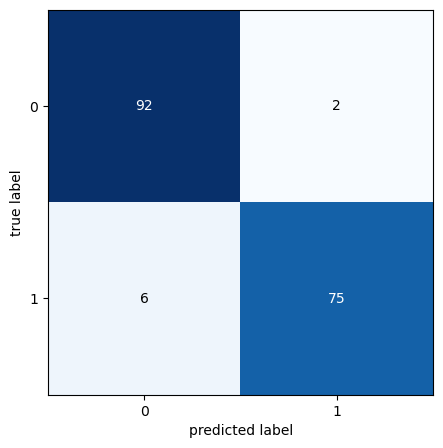

In [27]:
Evaluate(Xception)

0 1 0 1 0 

0


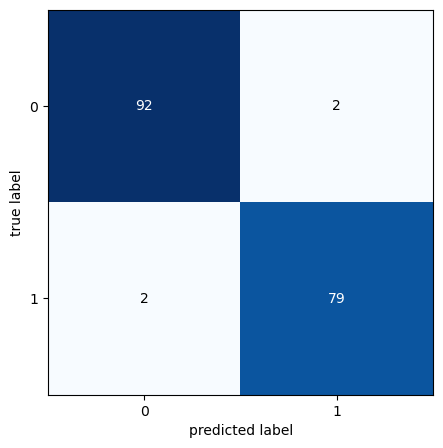

Accuracy: 97.714
Precision: 97.531
Recall: 97.531
False Positive: 2
Sensitivity: 97.531
Specificity: 97.872


In [65]:
LeNet_pred = Predicted(LeNet)
IV3_pred = Predicted(InceptionV3)
ResNet_pred = Predicted(ResNet)
VGG_pred = Predicted(Vgg)
XC_pred = Predicted(Xception)
print(LeNet_pred[45], IV3_pred[45],ResNet_pred[45],VGG_pred[45], XC_pred[45], "\n")
import numpy as np

def Majority_Predicted(LeNet_pred, IV3_pred, ResNet_pred, VGG_pred, XC_pred):
    
    Combine = np.vstack((LeNet_pred, IV3_pred, ResNet_pred, VGG_pred, XC_pred)).T
    majority_pred = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr= Combine)
    
    return majority_pred

majority_pred = Majority_Predicted(LeNet_pred, IV3_pred, ResNet_pred,VGG_pred, XC_pred)
print(majority_pred[45])



CM = CM(majority_pred)

TP = CM[1, 1]
TN = CM[0, 0]
FP = CM[0, 1]
FN = CM[1, 0]

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Accuracy:", round(accuracy * 100, 3)) 
print("Precision:", round(precision* 100, 3)) 
print("Recall:", round(recall  * 100, 3))
print("False Positive:", FP)
print("Sensitivity:", round(sensitivity * 100, 3))
print("Specificity:", round(specificity * 100, 3))

In [71]:
LeNet.save('LeNet.h5')
ResNet.save('ResNet.h5')
Xception.save('Xception.h5')
InceptionV3.save('InceptionV3.h5')
Vgg.save('VGG16.h5')

# **Testing - for Web Part**

In [ ]:
##                                           Single Image

# def SingleImage_Test(path):
#     image = ImagePreparation(path).reshape(224,224,3)
    
#     LeNet.load_weights("LeNet.h5")
#     LeNet.compile(optimizer='adamax',loss = 'binary_crossentropy',metrics=['accuracy'])
#     prediction_scores = LeNet.predict(np.expand_dims(image, axis=0))
#     predicted_index = np.argmax(prediction_scores)
#     print("Predicted label: " + Classes[predicted_index])
    

# image_path = "/kaggle/input/edrop-alltypes/Combined( All types -converted- 932)/RP 421/FAF_RP (100).jpg"
# SingleImage_Test(image_path)